In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def LoadAnnot_IFOMFormat_GT(AnnotPath, VideoShape, ZeroFrame = 1):
  print(f"Loading Annotation from: {AnnotPath}")
  AnnotFile = open(AnnotPath, 'r')
  AnnotDF = pd.DataFrame(columns = ["Frame", "ObjectID", "SegmentationRLE", "LocalTrackRLE",
                                    "Centroid", "SegBbox", "TrackBbox", "PrevID", "NextID", "TrackID", "Interpolated"])
  FirstRow = True
  PrevObjectID = -1
  PrevFrame = -1
  PolyLine = []
  MultiSegImg = np.zeros(VideoShape)
  for line in AnnotFile:
    if not FirstRow and line:
      splitted = line.split()
      Frame = int(splitted[0])
      ObjectID = splitted[1]
      x = int(float(splitted[2]))
      y = int(float(splitted[3]))
      if (ObjectID != PrevObjectID and PrevObjectID!=-1) or (Frame != PrevFrame and PrevFrame != -1):
        IndividualSegImg = np.zeros(VideoShape)
        cv2.fillPoly(IndividualSegImg,np.int32([PolyLine]),1)
        IndividualSegImg = np.array(IndividualSegImg, dtype=bool)
        MultiSegImg[IndividualSegImg] = PrevObjectID
        PolyLine = []
        if Frame != PrevFrame:
          AnnotRow = pd.Series({"Frame": PrevFrame - ZeroFrame, "IDMask": MultiSegImg})
          AnnotDF = pd.concat([AnnotDF, AnnotRow.to_frame().T], ignore_index=True)
          MultiSegImg = np.zeros(VideoShape)
      PrevObjectID = ObjectID
      PrevFrame = Frame
      PolyLine.append([x,y])
    FirstRow = False

  AnnotRow = pd.Series({"Frame": PrevFrame - ZeroFrame, "IDMask": MultiSegImg})
  AnnotDF = pd.concat([AnnotDF, AnnotRow.to_frame().T], ignore_index=True)

  return AnnotDF

def LoadAnnot_IFOMFormat_PRED(AnnotPath, VideoShape, ZeroFrame = 1):
  print(f"Loading Annotation from: {AnnotPath}")
  AnnotFile = open(AnnotPath, 'r')
  AnnotDF = pd.DataFrame(columns = ["Frame", "ObjectID", "SegmentationRLE", "LocalTrackRLE",
                                    "Centroid", "SegBbox", "TrackBbox", "PrevID", "NextID", "TrackID", "Interpolated"])
  FirstRow = True
  PrevObjectID = -1
  PrevFrame = -1
  PolyLine = []
  MultiSegImg = np.zeros(VideoShape)
  for line in AnnotFile:
    if not FirstRow and line:
      splitted = line.split()
      Frame = int(splitted[1])
      ObjectID = splitted[2]
      x = int(float(splitted[3]))
      y = int(float(splitted[4]))
      if (ObjectID != PrevObjectID and PrevObjectID!=-1) or (Frame != PrevFrame and PrevFrame != -1):
        IndividualSegImg = np.zeros(VideoShape)
        cv2.fillPoly(IndividualSegImg,np.int32([PolyLine]),1)
        IndividualSegImg = np.array(IndividualSegImg, dtype=bool)
        MultiSegImg[IndividualSegImg] = PrevObjectID
        PolyLine = []
        if Frame != PrevFrame:
          AnnotRow = pd.Series({"Frame": PrevFrame - ZeroFrame, "IDMask": MultiSegImg})
          AnnotDF = pd.concat([AnnotDF, AnnotRow.to_frame().T], ignore_index=True)
          MultiSegImg = np.zeros(VideoShape)
      PrevObjectID = ObjectID
      PrevFrame = Frame
      PolyLine.append([x,y])
    FirstRow = False

  AnnotRow = pd.Series({"Frame": PrevFrame - ZeroFrame, "IDMask": MultiSegImg})
  AnnotDF = pd.concat([AnnotDF, AnnotRow.to_frame().T], ignore_index=True)

  return AnnotDF

In [2]:
import requests
import zipfile
import os

def download_file(url, output_path):
    """
    Download a file from a given URL and save it to the specified output path.

    Args:
    url (str): The URL of the file to download.
    output_path (str): The path where the file will be saved.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded {output_path}")
    else:
        print(f"Failed to download {output_path}, status code: {response.status_code}")

def unzip_file(zip_path, extract_to='.'):
    """
    Unzip a file to the specified directory.

    Args:
    zip_path (str): The path to the zip file.
    extract_to (str): The directory to extract the files to. Defaults to the current directory.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {zip_path} to {extract_to}")

In [3]:
def LoadMOTSgt(file_path):
    data_list = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            data_entry = {
                'time_frame': int(parts[0]),
                'id': int(parts[1]),
                'class_id': int(parts[2]),
                'img_height': int(parts[3]),
                'img_width': int(parts[4]),
                'rle': parts[5]
            }
            if data_entry['class_id'] == 2:
              data_list.append(data_entry)

    return data_list

In [ ]:
!pip install lz4

import numpy as np
import lz4.frame as lz4frame
import pickle

def compress_np_img_lz4(img_array):
    img_array = img_array.astype(np.uint16)
    img_bytes = img_array.tobytes()
    compressed_img = lz4frame.compress(img_bytes)
    shape_info = img_array.shape
    compressed_data = pickle.dumps((shape_info, compressed_img))
    return compressed_data

def decompress_np_img_lz4(compressed_data):
    shape_info, compressed_img = pickle.loads(compressed_data)
    decompressed_bytes = lz4frame.decompress(compressed_img)
    decompressed_img = np.frombuffer(decompressed_bytes, dtype=np.uint16)
    decompressed_img = decompressed_img.reshape(shape_info)
    return decompressed_img

In [5]:
import numpy as np
import pickle
import zlib

def compress_np_img(img_array):
    img_array = img_array.astype(np.uint16)
    img_bytes = img_array.tobytes()
    compressed_img = zlib.compress(img_bytes)
    shape_info = img_array.shape
    compressed_data = pickle.dumps((shape_info, compressed_img))
    return compressed_data

def decompress_np_img(compressed_data):
    shape_info, compressed_img = pickle.loads(compressed_data)
    decompressed_bytes = zlib.decompress(compressed_img)
    decompressed_img = np.frombuffer(decompressed_bytes, dtype=np.uint16)
    decompressed_img = decompressed_img.reshape(shape_info)
    return decompressed_img

In [6]:
import pandas as pd

AllSampleFramewise = pd.DataFrame(columns = ["Dataset","SampleID","Frame","GroundTruth","SampleRatio","PredKalman","PredSymmetry","PredSymmetryL2","PredSymmetryShape","ValidSample"])
TrackerCategories = ["Kalman","Symmetry","SymmetryL2","SymmetryShape"]

In [ ]:
# Load Synthetic results

import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image

VideoShape = [512,512]
Frames = range(0,100)

ArrowSynthRootURL = "/path/to/data/"
ArrowSynthCategories = ["TurnsOften", "Shapes", "ShapesTP20", "ShapesTP5"]
#ArrowSynthCategories = ["1","Turns","Occlusions","Numbered","NumberedTP20","NumberedTP5"]
SampleRatios = ["1.0"]

for ASCategory in ArrowSynthCategories:
  for SR in SampleRatios:
    gt_name = f"ArrowSynth{ASCategory}_test_gt_labels.zip"
    gt_path = f"{ArrowSynthRootURL}/ArrowSynth{ASCategory}/data/{gt_name}"
    download_file(gt_path, gt_name)
    for TC in TrackerCategories:
      pred_name = f"ArrowSynth{ASCategory}_SR{SR}_{TC}.zip"
      pred_path = f"{ArrowSynthRootURL}/ArrowSynth{ASCategory}/predictions/ArrowSynth{ASCategory}_SR{SR}_{TC}.zip"
      download_file(pred_path, pred_name)

for ASCategory in ArrowSynthCategories:
  for SR in SampleRatios:

    gt_name = f"ArrowSynth{ASCategory}_test_gt_labels.zip"
    gt_path = f"{ArrowSynthRootURL}/ArrowSynth{ASCategory}/data/{gt_name}"
    unzip_file(gt_name)

    for TC in TrackerCategories:

      pred_name = f"ArrowSynth{ASCategory}_SR{SR}_{TC}.zip"
      pred_path = f"{ArrowSynthRootURL}/ArrowSynth{ASCategory}/predictions/ArrowSynth{ASCategory}_SR{SR}_{TC}.zip"
      unzip_file(pred_name)

    sample_gt_names = sorted(os.listdir("./gt_labels"))
    sample_ids = [sample_gt_name[0:3] for sample_gt_name in sample_gt_names]

    for sample_id in sample_ids:

      valid = True

      dfs_dict = {}

      gt_path = f"./gt_labels/{sample_id}_gt.txt"
      dfs_dict['GT'] = LoadAnnot_IFOMFormat_GT(gt_path, VideoShape)

      for TC in TrackerCategories:

        pred_path = f"./ArrowSynth{ASCategory}_SR{SR}_{TC}/{sample_id}.txt"
        dfs_dict[TC] = LoadAnnot_IFOMFormat_PRED(pred_path, VideoShape)

      for frame in Frames:
        try:
          gt_frame = compress_np_img(dfs_dict['GT'][dfs_dict[TC]["Frame"]==frame]["IDMask"].values[0])
        except:
          gt_frame = compress_np_img(np.zeros(VideoShape))
          valid = False
        FrameSample = pd.Series({"Dataset": f"ArrowSynth{ASCategory}", "SampleID": sample_id, "Frame":frame, "GroundTruth": gt_frame, "SampleRatio": SR})

        for TC in TrackerCategories:
          try:
            pred_frame = compress_np_img(dfs_dict[TC][dfs_dict[TC]["Frame"]==frame]["IDMask"].values[0])
          except:
            pred_frame = compress_np_img(np.zeros(VideoShape))
          FrameSample[f"Pred{TC}"] = pred_frame

        AllSampleFramewise = pd.concat([AllSampleFramewise, FrameSample.to_frame().T], ignore_index=True)

      AllSampleFramewise.loc[(AllSampleFramewise["Dataset"] == f"ArrowSynth{ASCategory}") & (AllSampleFramewise["SampleID"] == sample_id), "ValidSample"] = valid

    shutil.rmtree("./gt_labels")


In [ ]:
# Load MOTSynthCVPR22 results

# Original data source: https://motchallenge.net/data/MOTS/

import pycocotools.mask as rletools
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import pandas as pd

download_file("/path/to/MOTS20_TrackPreds.zip", "MOTS20_TrackPreds.zip")
unzip_file("MOTS20_TrackPreds.zip")

download_file("/path/to/MOTSLabels.zip", "MOTSLabels.zip")
unzip_file("MOTSLabels.zip")

MOTS_samples = ["MOTS20-02", "MOTS20-09", "MOTS20-11"]
MOTS_shape = [480,270]

for MOTS_sample in MOTS_samples:

  print(MOTS_sample)

  sample_id = MOTS_sample[7:]

  all_frames = {}

  # Loading gt data to all_frames

  print("Loading GT")

  gt_path = f"./MOTSLabels/train/{MOTS_sample}/gt/gt.txt"
  gt_list = LoadMOTSgt(gt_path)

  prev_frame = -1
  MultiSegImg = np.zeros([MOTS_shape[1], MOTS_shape[0]])

  gt_frames = {}

  for gt_row in gt_list:
    binary_mask = rletools.decode(
        {
          'counts': gt_row['rle'],
          'size': [gt_row['img_height'], gt_row['img_width']]
        })

    binary_mask = np.array(cv2.resize(binary_mask, MOTS_shape), dtype=bool)
    MultiSegImg[binary_mask] = gt_row['id']

    if gt_row['time_frame'] != prev_frame and prev_frame != -1:
      try:
        gt_frames[prev_frame-1] = compress_np_img(MultiSegImg)
      except:
        gt_frames[prev_frame-1] = compress_np_img(np.zeros([MOTS_shape[1], MOTS_shape[0]]))
      MultiSegImg = np.zeros([MOTS_shape[1], MOTS_shape[0]])

    prev_frame = gt_row['time_frame']

  try:
    gt_frames[prev_frame-1] = compress_np_img(MultiSegImg)
  except:
    gt_frames[prev_frame-1] = compress_np_img(np.zeros([MOTS_shape[1], MOTS_shape[0]]))

  all_frames["GT"] = gt_frames

  # Loading all pred data to all_frames

  for TC in TrackerCategories:

    print(f"Loading {TC} Prediction")

    pred_path = f"./MOTS20_TrackPreds/{MOTS_sample}_{TC}_Tracks.json"
    pred_DF = pd.DataFrame(json.load(open(pred_path)))

    MultiSegImg = np.zeros([MOTS_shape[1], MOTS_shape[0]])

    pred_frames = {}

    for frame in pred_DF["Frame"].unique():
      MultiSegImg = np.zeros([MOTS_shape[1], MOTS_shape[0]])
      for _, row in pred_DF[pred_DF["Frame"] == frame].iterrows():
        binary_mask = rletools.decode(row["SegmentationRLE"])
        binary_mask = np.array(cv2.resize(binary_mask, MOTS_shape), dtype=bool)
        MultiSegImg[binary_mask] = row["TrackID"]
      try:
        pred_frames[frame] = compress_np_img(MultiSegImg)
      except:
        pred_frames[frame] = compress_np_img(np.zeros([MOTS_shape[1], MOTS_shape[0]]))

    all_frames[TC] = pred_frames

  # Filling AllSampleFramewise

  print(f"Filling AllSampleFramewise")

  for frame in all_frames["GT"].keys():
    try:
      gt_frame = all_frames["GT"][frame]
    except:
      gt_frame = compress_np_img(np.zeros([MOTS_shape[1], MOTS_shape[0]]))

    FrameSample = pd.Series({"Dataset": f"MOTS20", "SampleID": sample_id, "Frame":frame, "GroundTruth": gt_frame, "SampleRatio": None, "ValidSample": True})

    for TC in TrackerCategories:
      try:
        pred_frame = all_frames[TC][frame]
      except:
        pred_frame = compress_np_img(np.zeros([MOTS_shape[1], MOTS_shape[0]]))

      FrameSample[f"Pred{TC}"] = pred_frame

    AllSampleFramewise = pd.concat([AllSampleFramewise, FrameSample.to_frame().T], ignore_index=True)

In [9]:
display(AllSampleFramewise)

,Dataset,SampleID,Frame,GroundTruth,SampleRatio,PredKalman,PredSymmetry,PredSymmetryL2,PredSymmetryShape,ValidSample
0,ArrowSynthTurnsOften,081,0,b'\x80\x04\x95\xdb\x06\x00\x00\x00\x00\x00\x00...,1.0,"b""\x80\x04\x95\x17\x06\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x17\x06\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x17\x06\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x17\x06\x00\x00\x00\x00\x00\x00...",True
1,ArrowSynthTurnsOften,081,1,b'\x80\x04\x95\x97\x06\x00\x00\x00\x00\x00\x00...,1.0,"b""\x80\x04\x95\xc5\x05\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x04\x06\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x04\x06\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\xc4\x05\x00\x00\x00\x00\x00\x00...,True
2,ArrowSynthTurnsOften,081,2,b'\x80\x04\x954\x06\x00\x00\x00\x00\x00\x00M\x...,1.0,"b""\x80\x04\x95\x9b\x05\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\x0e\x06\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x06\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x10\x06\x00\x00\x00\x00\x00\x00...,True
3,ArrowSynthTurnsOften,081,3,"b""\x80\x04\x95\x1c\x06\x00\x00\x00\x00\x00\x00...",1.0,"b""\x80\x04\x95\x94\x05\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x13\x06\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\xef\x05\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\x1b\x07\x00\x00\x00\x00\x00\x00...",True
4,ArrowSynthTurnsOften,081,4,"b""\x80\x04\x95\xd2\x05\x00\x00\x00\x00\x00\x00...",1.0,"b""\x80\x04\x95\x12\x05\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\xdf\x05\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\x82\x05\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95=\x07\x00\x00\x00\x00\x00\x00M\x...,True
...,...,...,...,...,...,...,...,...,...,...
7995,ArrowSynthShapesTP5,100,95,b'\x80\x04\x95\x00\x03\x00\x00\x00\x00\x00\x00...,1.0,b'\x80\x04\x95\xcd\x02\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95N\x03\x00\x00\x00\x00\x00\x00M\x...,b'\x80\x04\x95H\x03\x00\x00\x00\x00\x00\x00M\x...,b'\x80\x04\x95A\x03\x00\x00\x00\x00\x00\x00M\x...,True
7996,ArrowSynthShapesTP5,100,96,b'\x80\x04\x95\x00\x03\x00\x00\x00\x00\x00\x00...,1.0,b'\x80\x04\x95 \x03\x00\x00\x00\x00\x00\x00M\x...,"b""\x80\x04\x95\x01\x03\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\x1e\x03\x00\x00\x00\x00\x00\x00...,"b'\x80\x04\x95""\x03\x00\x00\x00\x00\x00\x00M\x...",True
7997,ArrowSynthShapesTP5,100,97,b'\x80\x04\x95a\x03\x00\x00\x00\x00\x00\x00M\x...,1.0,"b""\x80\x04\x95K\x03\x00\x00\x00\x00\x00\x00M\x...",b'\x80\x04\x95*\x03\x00\x00\x00\x00\x00\x00M\x...,b'\x80\x04\x95I\x03\x00\x00\x00\x00\x00\x00M\x...,"b""\x80\x04\x95K\x03\x00\x00\x00\x00\x00\x00M\x...",True
7998,ArrowSynthShapesTP5,100,98,"b'\x80\x04\x95""\x03\x00\x00\x00\x00\x00\x00M\x...",1.0,"b""\x80\x04\x95-\x03\x00\x00\x00\x00\x00\x00M\x...",b'\x80\x04\x95\x00\x03\x00\x00\x00\x00\x00\x00...,"b'\x80\x04\x95,\x03\x00\x00\x00\x00\x00\x00M\x...","b""\x80\x04\x95-\x03\x00\x00\x00\x00\x00\x00M\x...",True


In [ ]:
for Dataset in AllSampleFramewise["Dataset"].unique():
  print(f"{Dataset}:")
  display(AllSampleFramewise[AllSampleFramewise["Dataset"] == Dataset]["ValidSample"].value_counts())

Dataset: ArrowSynthTurnsOften
Sample 081, Frame 0


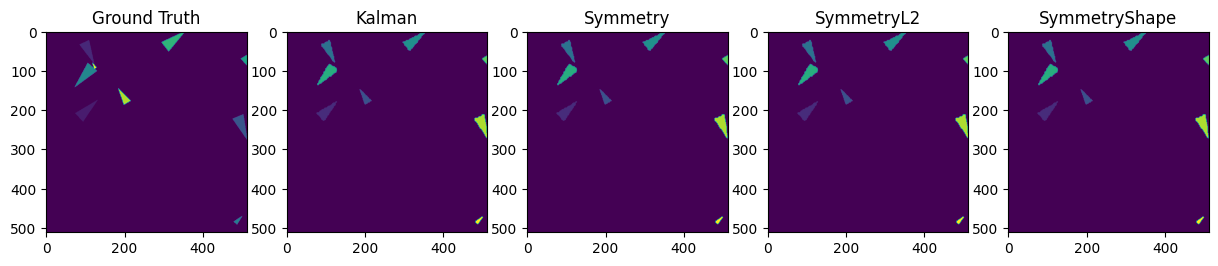

Sample 081, Frame 1


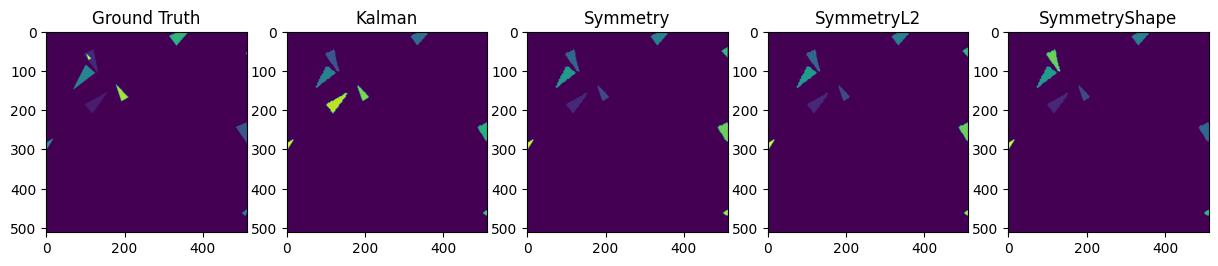

Sample 081, Frame 2


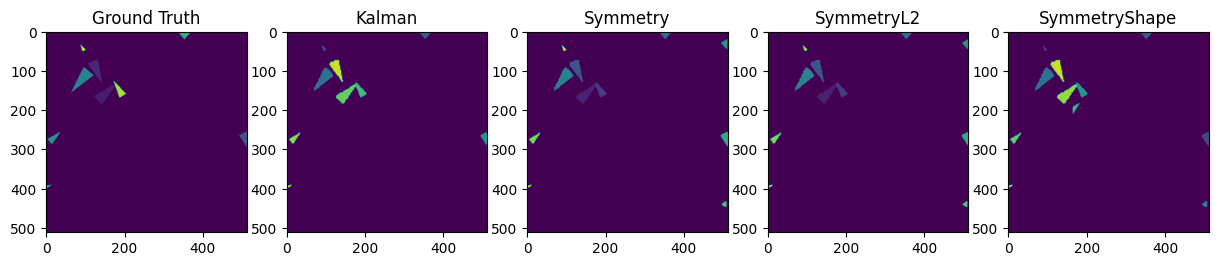

Dataset: ArrowSynthShapes
Sample 081, Frame 0


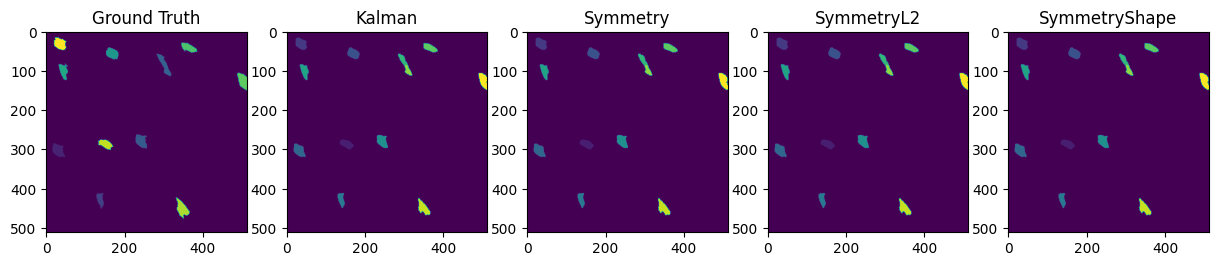

Sample 081, Frame 1


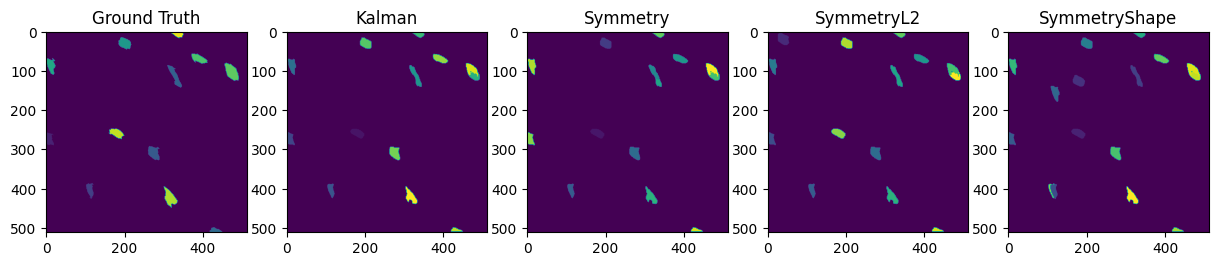

Sample 081, Frame 2


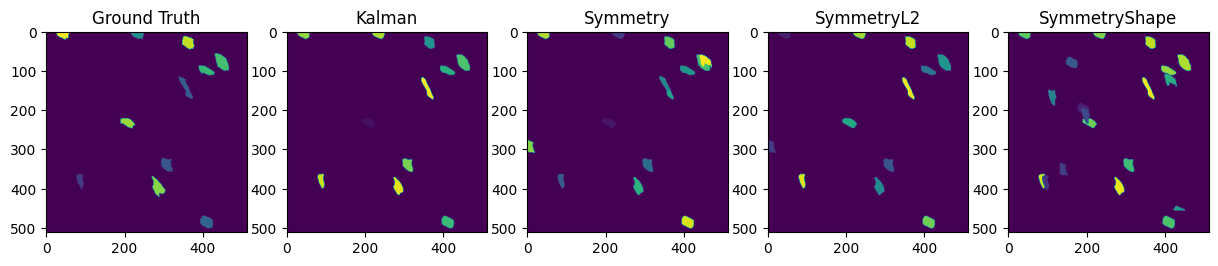

Dataset: ArrowSynthShapesTP20
Sample 082, Frame 0


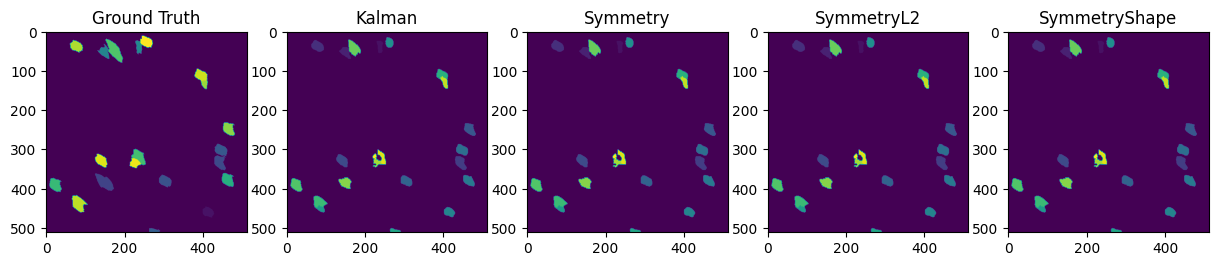

Sample 082, Frame 1


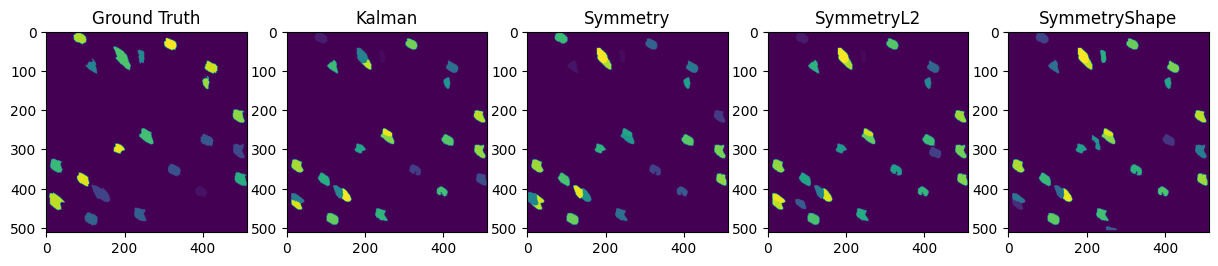

Sample 082, Frame 2


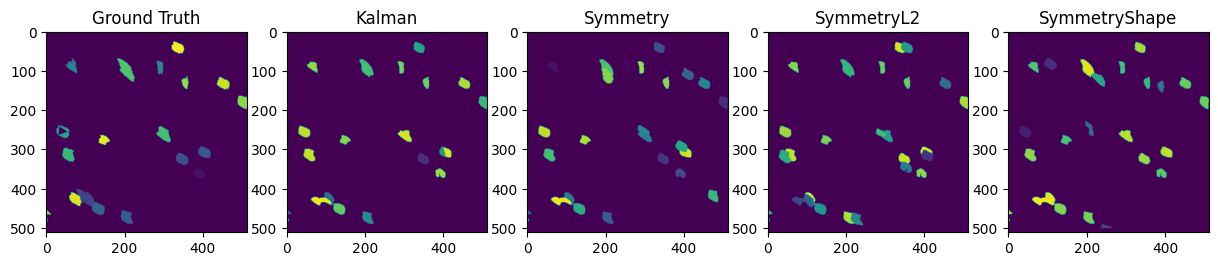

Dataset: ArrowSynthShapesTP5
Sample 081, Frame 0


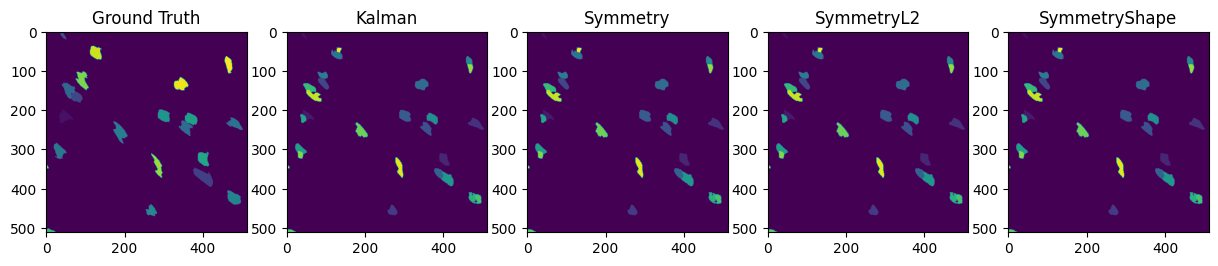

Sample 081, Frame 1


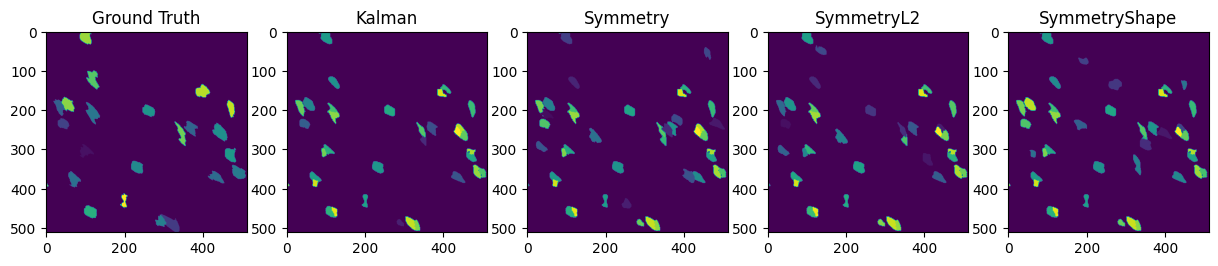

Sample 081, Frame 2


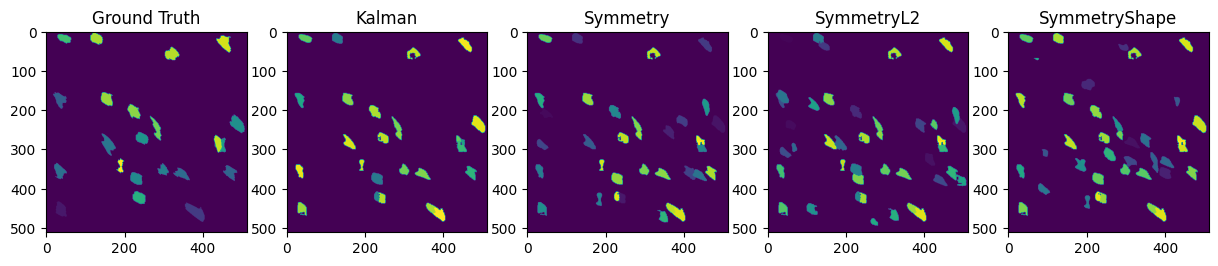

In [11]:
#Example iteration

import matplotlib.pyplot as plt

# show images and predictions as subplots

for Dataset in AllSampleFramewise["Dataset"].unique():
  print(f"Dataset: {Dataset}")
  for _ , row in AllSampleFramewise[AllSampleFramewise["ValidSample"] & (AllSampleFramewise["Dataset"] == Dataset)].head(3).iterrows():

    print(f'Sample {row["SampleID"]}, Frame {row["Frame"]}')

    fig, axes = plt.subplots(1, 5, figsize = [15,3])

    axes[0].imshow(decompress_np_img(row["GroundTruth"]))
    axes[0].set_title("Ground Truth")

    axes[1].imshow(decompress_np_img(row["PredKalman"]))
    axes[1].set_title("Kalman")

    axes[2].imshow(decompress_np_img(row["PredSymmetry"]))
    axes[2].set_title("Symmetry")

    axes[3].imshow(decompress_np_img(row["PredSymmetryL2"]))
    axes[3].set_title("SymmetryL2")

    axes[4].imshow(decompress_np_img(row["PredSymmetryShape"]))
    axes[4].set_title("SymmetryShape")

    plt.show()


In [12]:
#Export to pickle

AllSampleFramewise.to_pickle("GeneralSymmetricTracking_AllSamplesFramewise2.pkl")

In [ ]:
AllSampleFramewise2 = pd.read_pickle("GeneralSymmetricTracking_AllSamplesFramewise.pkl")